In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [5]:
df = pd.read_csv('RSCCASN.csv')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 334 entries, 0 to 333
Data columns (total 2 columns):
DATE       334 non-null object
RSCCASN    334 non-null int64
dtypes: int64(1), object(1)
memory usage: 5.3+ KB


In [8]:
df.DATE=pd.to_datetime(df.DATE)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 334 entries, 0 to 333
Data columns (total 2 columns):
DATE       334 non-null datetime64[ns]
RSCCASN    334 non-null int64
dtypes: datetime64[ns](1), int64(1)
memory usage: 5.3 KB


In [15]:
df.index = df.DATE

In [18]:
df.drop(columns=['DATE'], inplace = True)

In [20]:
df.head()

,RSCCASN
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558


In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 334 entries, 1992-01-01 to 2019-10-01
Data columns (total 1 columns):
RSCCASN    334 non-null int64
dtypes: int64(1)
memory usage: 5.2 KB


In [22]:
df.columns = ['Sales']

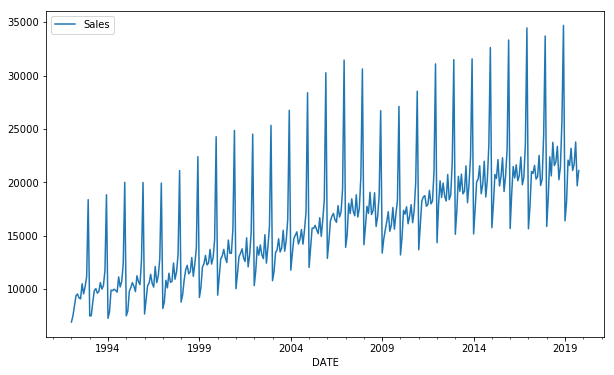

In [26]:
df.plot(figsize=(10,6))

In [27]:
# seasonality cycle in above data is around 12-18 months

In [30]:
test_size = 18
test_index = len(df) - test_size

In [32]:
train = df.iloc[:test_index]
test = df.iloc[test_index:]

In [34]:
test.shape, train.shape

((18, 1), (316, 1))

In [35]:
from sklearn.preprocessing import MinMaxScaler

In [36]:
sc = MinMaxScaler()


In [37]:
sc.fit(train)

MinMaxScaler()

In [38]:
scaled_train = sc.transform(train)
scaled_test = sc.transform(test)

In [39]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [40]:
# length should be less than 18 to avoid error 

In [42]:
length = 12
generator = TimeseriesGenerator(scaled_train, scaled_train, length=length,batch_size=1)

In [43]:
X,y = generator[0]

In [44]:
X

array([[[0.        ],
        [0.02127505],
        [0.05580163],
        [0.08942056],
        [0.09512053],
        [0.08146965],
        [0.07860151],
        [0.12979233],
        [0.09566512],
        [0.1203892 ],
        [0.15426227],
        [0.41595266]]])

In [45]:
y

array([[0.02047633]])

In [49]:
scaled_train[:13] # X, y are same as this

array([[0.        ],
       [0.02127505],
       [0.05580163],
       [0.08942056],
       [0.09512053],
       [0.08146965],
       [0.07860151],
       [0.12979233],
       [0.09566512],
       [0.1203892 ],
       [0.15426227],
       [0.41595266],
       [0.02047633]])

In [50]:
# modelling 

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

In [51]:
n_features = 1

In [52]:
model = Sequential()
model.add(LSTM(100,activation='relu',input_shape = (length, n_features)))
model.add(Dense(1))
model.compile( optimizer = 'adam', loss= 'mse')

In [53]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100)               40800     
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [54]:
from tensorflow.keras.callbacks import EarlyStopping

In [59]:
early_stop = EarlyStopping(monitor='val_loss', patience=5)

In [60]:
validation_generator = TimeseriesGenerator(scaled_test,scaled_test,length=length, batch_size=1)

In [61]:
model.fit_generator(generator,epochs=20,
                    validation_data=validation_generator,
                    callbacks=[early_stop])

Epoch 1/20
304/304 [==============================] - 3s 9ms/step - loss: 0.0026 - val_loss: 0.0019
Epoch 2/20
304/304 [==============================] - 3s 11ms/step - loss: 0.0019 - val_loss: 0.0047
Epoch 3/20
304/304 [==============================] - 3s 10ms/step - loss: 0.0017 - val_loss: 2.7636e-04
Epoch 4/20
304/304 [==============================] - 4s 14ms/step - loss: 0.0017 - val_loss: 8.2234e-04
Epoch 5/20
304/304 [==============================] - 4s 14ms/step - loss: 0.0011 - val_loss: 0.0015
Epoch 6/20
304/304 [==============================] - 4s 14ms/step - loss: 0.0011 - val_loss: 0.0012
Epoch 7/20
304/304 [==============================] - 4s 14ms/step - loss: 0.0021 - val_loss: 0.0153
Epoch 8/20
304/304 [==============================] - 4s 14ms/step - loss: 0.0016 - val_loss: 0.0020


In [62]:
loss = pd.DataFrame(model.history.history)

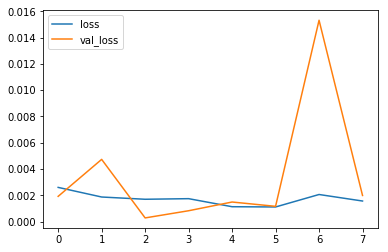

In [63]:
loss.plot()

In [82]:
# Predictions

# evaluate the model for complete test data

test_pred = []

eval_batch = scaled_train[-length:]

eval_batch=eval_batch.reshape((1,length,n_features))

for i in range(len(scaled_test)):
    
    pred = model.predict(eval_batch)[0]
    
    test_pred.append(pred)
    
    eval_batch = np.append(eval_batch[:,1:,:],[[pred]],axis=1)

In [90]:
true_predictions = sc.inverse_transform(test_pred)


In [91]:
test['true_pred'] = true_predictions

C:\Users\Mein Pc\.conda\envs\nlp_course\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


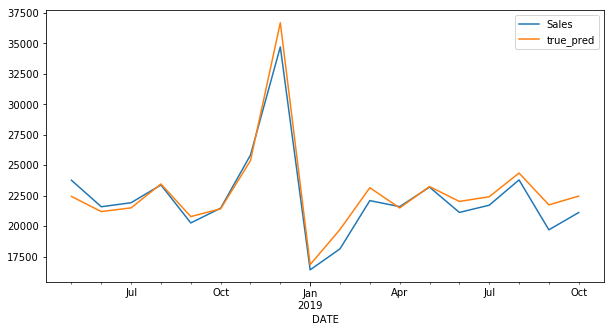

In [95]:
test.plot(figsize=(10,5))

## Forecasting 

In [96]:
full_scaler = MinMaxScaler()
scaled_full = full_scaler.fit_transform(df)

In [97]:
length = 12
generator = TimeseriesGenerator(scaled_full,scaled_full, length=length, batch_size=1)

In [99]:
model = Sequential()
model.add(LSTM(100,activation='relu', input_shape = (length,n_features)))
model.add( Dense(1))
model.compile( optimizer = 'adam', loss='mse')

model.fit_generator(generator, epochs=8)

Epoch 1/8
322/322 [==============================] - 4s 11ms/step - loss: 0.0238
Epoch 2/8
322/322 [==============================] - 4s 11ms/step - loss: 0.0188
Epoch 3/8
322/322 [==============================] - 3s 10ms/step - loss: 0.0107
Epoch 4/8
322/322 [==============================] - 4s 12ms/step - loss: 0.0052
Epoch 5/8
322/322 [==============================] - 3s 9ms/step - loss: 0.0028
Epoch 6/8
322/322 [==============================] - 3s 9ms/step - loss: 0.0021
Epoch 7/8
322/322 [==============================] - 4s 12ms/step - loss: 0.0016
Epoch 8/8
322/322 [==============================] - 3s 9ms/step - loss: 0.0014


In [101]:
# Predictions

# evaluate the model for complete test data

forecast = []

periods = 12

eval_batch = scaled_train[-length:]

eval_batch=eval_batch.reshape((1,length,n_features))

for i in range(periods):
    
    pred = model.predict(eval_batch)[0]
    
    forecast.append(pred)
    
    eval_batch = np.append(eval_batch[:,1:,:],[[pred]],axis=1)

In [102]:
true_forecast = full_scaler.inverse_transform(forecast)

In [105]:
true_forecast.shape

(12, 1)

In [109]:
forecast_index = pd.date_range(start='2019-11-01', periods= periods, freq='MS')

## pandas frequecy search

In [110]:
forecast_index

DatetimeIndex(['2019-11-01', '2019-12-01', '2020-01-01', '2020-02-01',
               '2020-03-01', '2020-04-01', '2020-05-01', '2020-06-01',
               '2020-07-01', '2020-08-01', '2020-09-01', '2020-10-01'],
              dtype='datetime64[ns]', freq='MS')

In [111]:
forecast_df = pd.DataFrame(data= true_forecast, index= forecast_index, columns=['Forecast'])

In [112]:
forecast_df

,Forecast
2019-11-01,22021.882584
2019-12-01,20920.011817
2020-01-01,21208.103797
2020-02-01,22957.710230
2020-03-01,20491.524173
2020-04-01,21189.053576
2020-05-01,25206.182544
2020-06-01,36274.675672
2020-07-01,16306.321275
2020-08-01,19068.089475


In [113]:
# concat with original

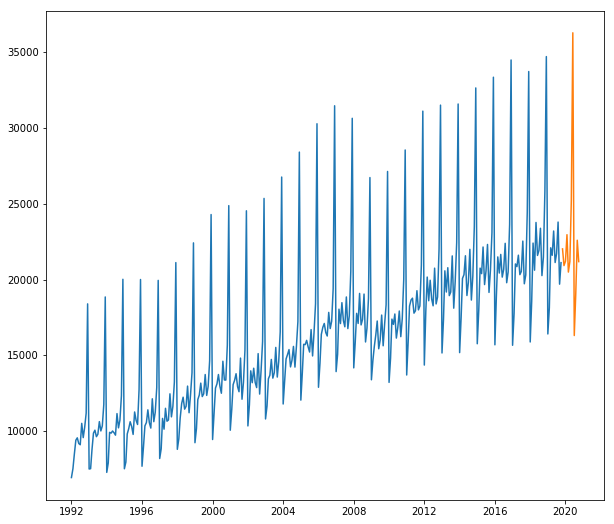

In [118]:
plt.figure(figsize= (10,9))
plt.plot(df.index,df.Sales)
plt.plot(forecast_df.index,forecast_df.Forecast)

## Nice !!